In [1]:
# Load dataset
import torch

# Parameters
num_epochs = 100
num_samples = 32
num_features = 128
rank = 32  # MPS rank
n_cores = 1 # max_monomial_degree
d_in = (num_features // n_cores)

# Generate random x data
x = torch.randn(num_samples, num_features).abs()

# Define polynomial function
def poly_fn(x):
    return x.abs().sum()

def add_bias(batch):
    # Stack tensors
    x, y = zip(*batch)  # unzip list of tuples into two tuples
    x = torch.stack(x, dim=0)
    y = torch.stack(y, dim=0)
   
    # Reshape x to be (B, H, D_in)
    x = x.reshape(x.size(0), n_cores, d_in)

    # Add bias term
    x = torch.cat([torch.ones(x.size(0), x.size(1), 1), x], dim=-1)
    return x, y

# Use torch.vmap to vectorize polynomial computation
y = torch.vmap(poly_fn)(x)
y = y.unsqueeze(1)  # (num_samples, 1)

# Create tensor dataset
dataset = torch.utils.data.TensorDataset(x, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=add_bias)


In [2]:
from tqdm import tqdm
def train_mps(model, num_epochs, dataloader, method="adam", lr=1e-3):

    if method == "adam":
        print("Training with AdamW")
        losses = []
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        pbar = tqdm(range(num_epochs))
        for epoch in pbar:
            for batch in dataloader:
                optimizer.zero_grad()
                x, y = batch
                output = model(x, y)
                loss = output.loss
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            pbar.set_postfix(loss=loss.item())

    else:
        print("Training with LBFGS")
        losses = []
        optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)
        pbar = tqdm(range(num_epochs))
        for epoch in pbar:
            for batch in dataloader:
                x, y = batch
                def closure():
                    optimizer.zero_grad()
                    output = model(x, y)
                    loss = output.loss
                    loss.backward()
                    return loss
                optimizer.step(closure)

                output = model(x, y)
                loss = output.loss
                losses.append(loss.item())
                pbar.set_postfix(loss=loss.item())
    
    return losses



In [ ]:
from tqdm import tqdm
from ptn.regressors.mps import MPS_REGRESSOR
from ptn.regressors._abc import AbstractRegressorHeadConfig


sample_batch = next(iter(dataloader))
x, y = sample_batch

model = MPS_REGRESSOR(
    AbstractRegressorHeadConfig(
        d_in=x.size(-1),
        d_out=y.size(-1),
        horizon=x.size(1),
        rank=rank,
    )
)

losses_adam = []
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    for batch in dataloader:
        optimizer.zero_grad()
        x, y = batch
        output = model(x, y)
        loss = output.loss
        loss.backward()
        optimizer.step()
        losses_adam.append(loss.item())
    pbar.set_postfix(loss=loss.item())

losses_lbfgs = []
optimizer = torch.optim.LBFGS(model.parameters(), lr=1e-3)
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    for batch in dataloader:
        x, y = batch
        def closure():
            optimizer.zero_grad()
            output = model(x, y)
            loss = output.loss
            loss.backward()
            return loss
        optimizer.step(closure)

        output = model(x, y)
        loss = output.loss
        losses_lbfgs.append(loss.item())
        pbar.set_postfix(loss=loss.item())
print("Training complete.")



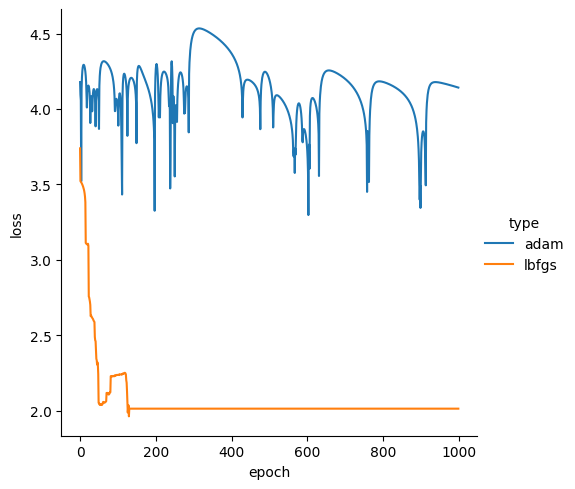

In [59]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

rows = (
        [{'type': 'adam', 'loss': loss, 'epoch': i} for i, loss in enumerate(losses_adam)] + 
        [{'type': 'lbfgs', 'loss': loss, 'epoch': i} for i, loss in enumerate(losses_lbfgs)]
    )
loss_df = pd.DataFrame(rows)
sns.relplot(
    data=loss_df,
    x='epoch',
    y='loss',
    hue='type',
    kind='line',
)
plt.show()


## Polynomial regression

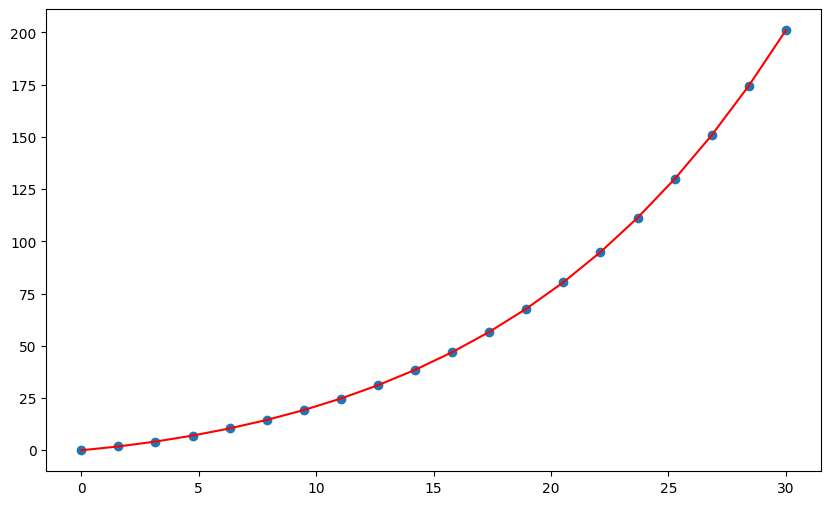

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import matplotlib.pyplot as plt

def poly_fn(x):
    return x + 1e-1*x**2 + 1e-4*x**4

# Hyperparameters
degree = 8
batch_size = 32
rank = 32
num_epochs = 100
num_samples = 1000
num_test_samples = 10
domain = 30

# Create data
x = np.random.uniform(low=0, high=domain, size=(num_samples,))
y = poly_fn(x)

poly_feats = PolynomialFeatures(degree=degree, include_bias=False)
x_poly = poly_feats.fit_transform(x.reshape(-1, 1))  # (B, Deg)

# Train model
poly_reg_model = LinearRegression()
poly_reg_model.fit(x_poly, y)

# Evaluate model
x_grid = np.linspace(0, 30, 20)
x_grid_poly = poly_feats.fit_transform(x_grid.reshape(-1, 1))  # (B, Deg)
y_grid = poly_fn(x_grid)
y_predicted = poly_reg_model.predict(x_grid_poly)

plt.figure(figsize=(10, 6))
plt.scatter(x_grid, y_grid)
plt.plot(x_grid, y_predicted, c="red")
plt.show()



Training with AdamW


100%|██████████| 100/100 [00:18<00:00,  5.29it/s, loss=2.02e+3]


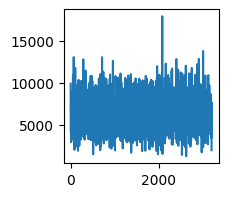

In [8]:
import torch
import seaborn as sns
from tqdm import tqdm
from ptn.regressors.mps import MPS_REGRESSOR
from ptn.regressors._abc import AbstractRegressorHeadConfig

def poly_fn(z):
    return z + 1e-1*z**2 + 1e-4*z**4

def make_mps_x(x):
    x = x.reshape(-1, 1).repeat(1, degree)
    x = torch.cat([torch.ones(x.size(0), x.size(1), 1), x.unsqueeze(-1)], dim=-1)
    return x

# Create data
x = torch.rand(num_samples) * domain
y = poly_fn(x).reshape(-1, 1)
x = make_mps_x(x)

dataset = torch.utils.data.TensorDataset(x, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train model
mps = MPS_REGRESSOR(
    AbstractRegressorHeadConfig(
        d_in=2,
        d_out=1,
        horizon=x.size(1),
        rank=rank,
        use_scale_factors=False,
    )
)

losses = train_mps(mps, dataloader=dataloader, num_epochs=num_epochs, method="adam", lr=1e-3)
plt.figure(figsize=(2, 2))
sns.lineplot(x=range(len(losses)), y=losses)
plt.show()


In [9]:
# Get MPS predictions on test set
x_grid = torch.rand(num_test_samples) * domain
y_grid = poly_fn(x_grid).reshape(-1, 1)
x_mps = make_mps_x(x_grid)
outputs = mps(x_mps)
y_pred_mps = outputs.logits * outputs.gammas.prod(dim=-1)

In [10]:
# Get scikit-learn predictions on test set
x_grid = np.linspace(0, domain, num_test_samples)
x_grid_poly = poly_feats.fit_transform(x_grid.reshape(-1, 1))  # (B, Deg)
y_grid = poly_fn(x_grid)
y_predicted = poly_reg_model.predict(x_grid_poly)

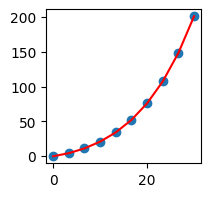

In [12]:
# Plot predictions
plt.figure(figsize=(2, 2))
plt.scatter(x_grid, y_grid)
plt.plot(x_grid, y_predicted, c="red")
# plt.plot(x_grid, y_pred_mps.detach().numpy(), c="blue")
plt.show()